In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 33.4 MB/s eta 0:00:00


# AMPC_Chem_Fg



## Chemical Attention Analysis

This section analyzes how attention mechanisms in chemical models focus on different chemical features including numeric tokens, ring structures, chiral centers, and bond types.

## 1. Setup and Imports


In [ ]:
import pickle
import gzip
import torch
import numpy as np
from rdkit import Chem
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Set style for plots
plt.style.use("ggplot")

In [ ]:
# Configuration
HEAD_LAYER_INDEX = [1, 2, 3, 11, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

# Generate head layer labels
head_layer_labels = []
for i in range(3):
    for j in range(12):
        if (i * 12 + j) in HEAD_LAYER_INDEX:
            head_layer_labels.append(f'l:{i} , h:{j}')

## 2. Data Loading Functions


In [ ]:
def load_smiles_data(file_path):
    """Load SMILES data from gzipped pickle file"""
    smiles_data = []
    with gzip.open(file_path, 'rb') as f:
        while True:
            try:
                smiles_data.extend(pickle.load(f))
            except EOFError:
                break
    return smiles_data

def load_all_smiles(file_path):
    """Load all SMILES from pickle file"""
    with open(file_path, "rb") as f:
        return pickle.load(f)

def load_pickle_data(file_path):
    """Load data from pickle file"""
    with open(file_path, "rb") as f:
        return pickle.load(f)

**Attention Matrix Extraction and Binarization**

To efficiently conduct our analyses, we extract the full attention matrices from the pre-trained ChemBERTa-MLM-77M model for all SMILES sequences in our dataset. Each attention matrix is then binarized using an adaptive threshold (estimated with kernel density estimation) to distinguish significant attention weights from background noise. The processed data—including original attention values and their binarized forms—are stored in compressed pickle files.

This preprocessing step ensures that we do not need to repeatedly recompute attentions from the model, making subsequent experiments faster and more reproducible.

In [ ]:
from tqdm.auto import tqdm
import torch
import numpy as np
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

def get_Threshold(att):
  arr = torch.flatten(att).cpu().numpy()
  kde = gaussian_kde(arr)
  x = torch.linspace(np.min(arr), np.max(arr), 100)
  y = kde(x)
  min_idx = argrelextrema(y, np.less)[0]
  min_peaks = x[min_idx]
  if len(min_peaks != 0):
    return min_peaks[0]
  return np.mean(arr)+np.std(arr)*2


# from transformers import AutoTokenizer, AutoModelForMaskedLM


# model = AutoModelForMaskedLM.from_pretrained('DeepChem/ChemBERTa-77M-MLM',output_attentions=True)
# tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-77M-MLM')

# import pickle
# import gzip

# f = gzip.open("/content/drive/MyDrive/ChemBERTa Attention Analysis/smiles_attention_data.pkl.gz", 'wb')

# progress_bar = tqdm(range(len(my_smiles)))

# smiles_data = []
# for s in my_smiles:
#   with torch.no_grad():
#     input = tokenizer(s,return_tensors='pt', truncation=True)
#     output = model(**input, output_attentions=True)
#   labels = tokenizer.decode(input.input_ids[0])[5:-5]
#   A = []
#   M = []
#   for l in range(3):
#     layer1 = []
#     layer2 = []
#     for h in range(12):
#       att = output.attentions[l][0][h]
#       layer1.append(att)
#       layer2.append(att > get_Threshold(att))
#     A.append(torch.stack(layer1))
#     M.append(torch.stack(layer2))
#   A = torch.stack(A, dim=0)
#   M = torch.stack(M, dim=0)
#   smiles_data.append({'tokens':labels , 'A':A, 'M':M})
#   if len(smiles_data)==1000:
#     pickle.dump(smiles_data,f)
#     smiles_data = []
#   progress_bar.update(1)

# pickle.dump(smiles_data,f)


all_smiles = load_all_smiles("/content/drive/MyDrive/ChemBERTa Attention Analysis/all_smiles")
smiles_data = load_smiles_data("/content/drive/MyDrive/ChemBERTa Attention Analysis/smiles_attention_data.pkl.gz")
my_smiles = load_pickle_data("/content/drive/MyDrive/ChemBERTa Attention Analysis/smiles with data")
map_chiral_index = load_pickle_data("/content/drive/MyDrive/ChemBERTa Attention Analysis/map_chiral_index.pkl")

## 3. Analysis Functions (F-measure and NAW-measure)

In [ ]:
def get_measure_data(index, layer, head, vec2):
    """Calculate measurement data for a specific attention head and target vector"""
    data = smiles_data[index]
    vec1 = data['M'][layer, head][:, 1:-1].any(0) # E^{d,l,h} (Attention vectorization)

    # Calculate confusion matrix
    TP = torch.logical_and(vec1, vec2).sum().item()
    FP = torch.logical_and(vec1, ~vec2).sum().item()
    FN = torch.logical_and(~vec1, vec2).sum().item()
    TN = torch.logical_and(~vec1, ~vec2).sum().item()

    # Calculate attention weights
    att = torch.where(data['M'][layer, head] > 0, data['A'][layer, head], 0)[:, 1:-1]
    idx = torch.where(vec2)[0]
    wocc = att[:, idx].sum().item() if len(idx) > 0 else 0

    total_att = att.sum().item()

    return TP, FP, FN, wocc, total_att

def analyze_pattern(pattern_type, pattern_func=None, chiral_indices=None):
    """
    Analyze attention patterns for a specific pattern type

    Args:
        pattern_type: Type of pattern to analyze ('digits', 'ring', 'double bond', 'triple bond', 'chiral')
        pattern_func: Optional function to generate the target vector
        chiral_indices: For chiral analysis, the indices of chiral molecules
    """
    print(f"Analyzing {pattern_type} pattern...")

    all_tp, all_fp, all_fn = [], [], []
    all_count, all_wocc, all_sum = [], [], []

    progress_bar = tqdm(total=len(HEAD_LAYER_INDEX))

    for layer in range(3):
        for head in range(12):
            if (layer * 12 + head) in HEAD_LAYER_INDEX:
                sum_tp, sum_fp, sum_fn = 0, 0, 0
                sum_count, sum_wocc, sum_total = 0, 0, 0

                # Determine which indices to process
                indices_range = range(len(smiles_data))
                if pattern_type == 'chiral' and chiral_indices is not None:
                    indices_range = chiral_indices.keys()

                for index in indices_range:
                    # Generate ground-truth vector based on pattern type
                    if pattern_func:
                        vec2 = pattern_func(index)
                    else:
                        vec2 = generate_ground_truth_vector(pattern_type, index)

                    if vec2.sum().item() != 0:
                        TP, FP, FN, wocc, total_att = get_measure_data(index, layer, head, vec2)

                        # For chiral patterns, only include if wocc is not zero
                        if pattern_type != 'chiral' or wocc != 0:
                            sum_tp += TP
                            sum_fp += FP
                            sum_fn += FN
                            sum_count += vec2.sum().item()
                            sum_wocc += wocc
                            sum_total += total_att

                all_tp.append(sum_tp)
                all_fp.append(sum_fp)
                all_fn.append(sum_fn)
                all_count.append(sum_count)
                all_wocc.append(sum_wocc)
                all_sum.append(sum_total)

                progress_bar.update(1)

    progress_bar.close()
    return all_tp, all_fp, all_fn, all_count, all_wocc, all_sum

def generate_ground_truth_vector(pattern_type, index):
    """Generate ground-truth vector based on pattern type"""
    if pattern_type == 'digits':
        # Numeric characters
        vec2 = []
        for c in smiles_data[index]['tokens']:
            vec2.append(c.isnumeric())
        return torch.tensor(vec2)

    elif pattern_type == 'ring':
        # Atoms in rings
        mol = Chem.MolFromSmiles(my_smiles[index])
        atom_IsInRing = [atom.IsInRing() for atom in mol.GetAtoms()]
        vec2 = []
        ai = 0
        for c in smiles_data[index]['tokens']:
            if c.isalpha():
                vec2.append(atom_IsInRing[ai])
                ai += 1
            else:
                vec2.append(False)
        return torch.tensor(vec2)

    elif pattern_type == 'chiral':
        # Chiral atoms
        mol = Chem.MolFromSmiles(all_smiles[map_chiral_index[index][0]])
        atom_IsChiral = [str(atom.GetChiralTag()) != 'CHI_UNSPECIFIED' for atom in mol.GetAtoms()]
        vec2 = []
        ai = 0
        for c in smiles_data[index]['tokens']:
            if c.isalpha():
                vec2.append(atom_IsChiral[ai])
                ai += 1
            else:
                vec2.append(False)
        return torch.tensor(vec2)

    elif pattern_type == 'double bond':
        # Bond characters (=)
        vec2 = []
        for c in smiles_data[index]['tokens']:
            vec2.append(c == '=')
        return torch.tensor(vec2)

    elif pattern_type == 'triple bond':
        # Bond characters (#)
        vec2 = []
        for c in smiles_data[index]['tokens']:
            vec2.append(c == '#')
        return torch.tensor(vec2)

    else:
        raise ValueError(f"Unknown pattern type: {pattern_type}")

def calculate_metrics(all_tp, all_fp, all_fn, all_count, all_wocc, all_sum):
    """Calculate various metrics from the analysis results"""
    f_m, n_w, r_c = [], [], []
    pre, recal, acc = [], [], []

    for i in range(len(all_tp)):
        TP = all_tp[i]
        FP = all_fp[i]
        FN = all_fn[i]
        count = all_count[i]
        wocc = all_wocc[i]
        total_sum = all_sum[i]

        # Avoid division by zero
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f_measure = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
        normalized_weight = wocc / total_sum if total_sum > 0 else 0
        recall_count = TP / count if count > 0 else 0

        pre.append(precision)
        recal.append(recall)
        f_m.append(f_measure)
        n_w.append(normalized_weight)
        r_c.append(recall_count)

    return f_m, n_w, r_c, pre, recal

def get_layer_head_label(s):
    """Extract layer and head from label string"""
    sp1 = s.split(',')
    l = sp1[0].split(':')[1].strip()
    h = sp1[1].split(':')[1].strip()
    return f'<{l},{h}>'

def plot_results(y1, y2, title, save_path=None):
    """Plot results using boxplots"""
    fig, ax = plt.subplots(figsize=(8, 6))

    colors = ["C0", "C5"]
    box = ax.boxplot([y1, y2], patch_artist=True)

    # Set colors for the boxplots
    for patch, color in zip(box['boxes'], colors[:2]):
        patch.set_facecolor(color)

    ax.set_ylabel('Values', fontsize=10)
    ax.set_xlabel('Metrics', fontsize=10)
    ax.set_xticklabels(['NW', 'F'])
    ax.set_title(title, fontsize=12)

    # Handle outliers
    outliers_1 = box['fliers'][0].get_data()[1]
    outlier_labels_1 = []
    for outlier in outliers_1:
        outlier_labels_1.append(get_layer_head_label(
            np.array(head_layer_labels)[np.where(np.array(y1) == outlier)[0][0]]))

    outliers_2 = box['fliers'][1].get_data()[1]
    outlier_labels_2 = []
    for outlier in outliers_2:
        outlier_labels_2.append(get_layer_head_label(
            np.array(head_layer_labels)[np.where(np.array(y2) == outlier)[0][0]]))

    # Add outlier labels
    for i in range(len(outlier_labels_1)):
        if outlier_labels_1[i] in outlier_labels_2:
            ax.text(1.03, outliers_1[i], outlier_labels_1[i],
                    ha='left', va='center', fontsize=10, color='black')
            ax.text(2.03, outliers_2[np.where(np.array(outlier_labels_2) == outlier_labels_1[i])[0][0]],
                    outlier_labels_1[i], ha='left', va='center', fontsize=10, color='black')
        else:
            ax.text(1.03, outliers_1[i], outlier_labels_1[i],
                    ha='left', va='center', fontsize=10, color='black')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


## 4. Analysis Execution

=== Analyzing Numeric Pattern ===
Analyzing digits pattern...


  0%|          | 0/23 [00:00<?, ?it/s]

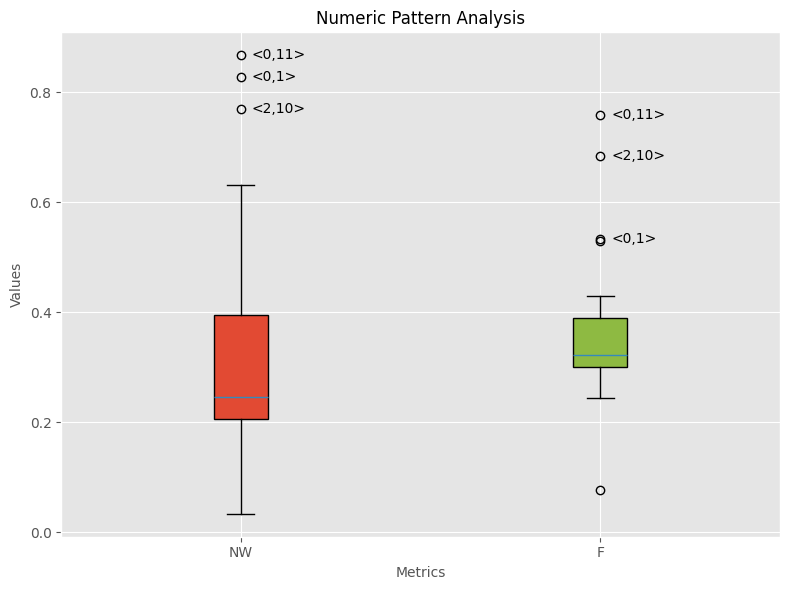

In [ ]:
# Analyze numeric pattern
print("=== Analyzing Numeric Pattern ===")
all_tp_num, all_fp_num, all_fn_num, all_count_num, all_wocc_num, all_sum_num = analyze_pattern('digits')
f_m_num, n_w_num, r_c_num, pre_num, recal_num = calculate_metrics(
    all_tp_num, all_fp_num, all_fn_num, all_count_num, all_wocc_num, all_sum_num)

plot_results(n_w_num, f_m_num, "Numeric Pattern Analysis", 'numeric_pattern.png')

=== Analyzing Ring Pattern ===
Analyzing ring pattern...


  0%|          | 0/23 [00:00<?, ?it/s]

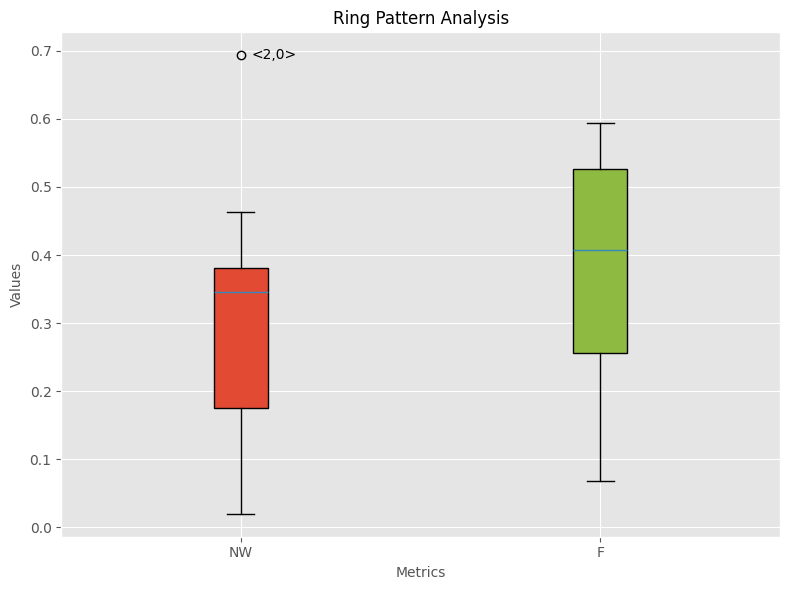

In [ ]:
# Analyze ring pattern
print("=== Analyzing Ring Pattern ===")
all_tp_ring, all_fp_ring, all_fn_ring, all_count_ring, all_wocc_ring, all_sum_ring = analyze_pattern('ring')
f_m_ring, n_w_ring, r_c_ring, pre_ring, recal_ring = calculate_metrics(
    all_tp_ring, all_fp_ring, all_fn_ring, all_count_ring, all_wocc_ring, all_sum_ring)

plot_results(n_w_ring, f_m_ring, "Ring Pattern Analysis", 'ring_pattern.png')

=== Analyzing Chiral Pattern ===
Analyzing chiral pattern...


  0%|          | 0/23 [00:00<?, ?it/s]

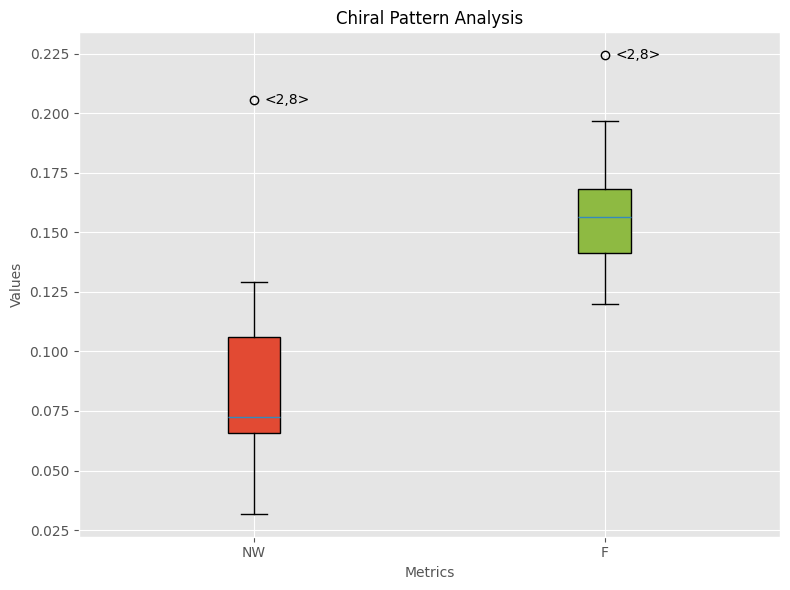

In [ ]:
# Analyze chiral pattern
print("=== Analyzing Chiral Pattern ===")
all_tp_chiral, all_fp_chiral, all_fn_chiral, all_count_chiral, all_wocc_chiral, all_sum_chiral = analyze_pattern(
    'chiral', chiral_indices=map_chiral_index)
f_m_chiral, n_w_chiral, r_c_chiral, pre_chiral, recal_chiral = calculate_metrics(
    all_tp_chiral, all_fp_chiral, all_fn_chiral, all_count_chiral, all_wocc_chiral, all_sum_chiral)

plot_results(n_w_chiral, f_m_chiral, "Chiral Pattern Analysis", 'chiral_pattern.png')

=== Analyzing Double Bond Pattern ===
Analyzing double bond pattern...


  0%|          | 0/23 [00:00<?, ?it/s]

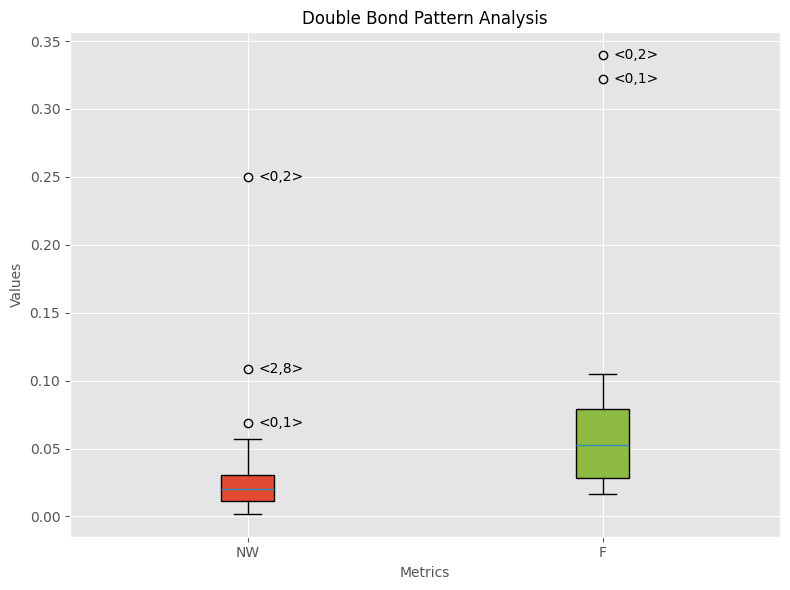

In [ ]:
# Analyze bond pattern
print("=== Analyzing Double Bond Pattern ===")
all_tp_bond, all_fp_bond, all_fn_bond, all_count_bond, all_wocc_bond, all_sum_bond = analyze_pattern('double bond')
f_m_bond, n_w_bond, r_c_bond, pre_bond, recal_bond = calculate_metrics(
    all_tp_bond, all_fp_bond, all_fn_bond, all_count_bond, all_wocc_bond, all_sum_bond)

plot_results(n_w_bond, f_m_bond, "Double Bond Pattern Analysis", 'double_bond_pattern.png')

=== Analyzing Triple Bond Pattern ===
Analyzing triple bond pattern...


  0%|          | 0/23 [00:00<?, ?it/s]

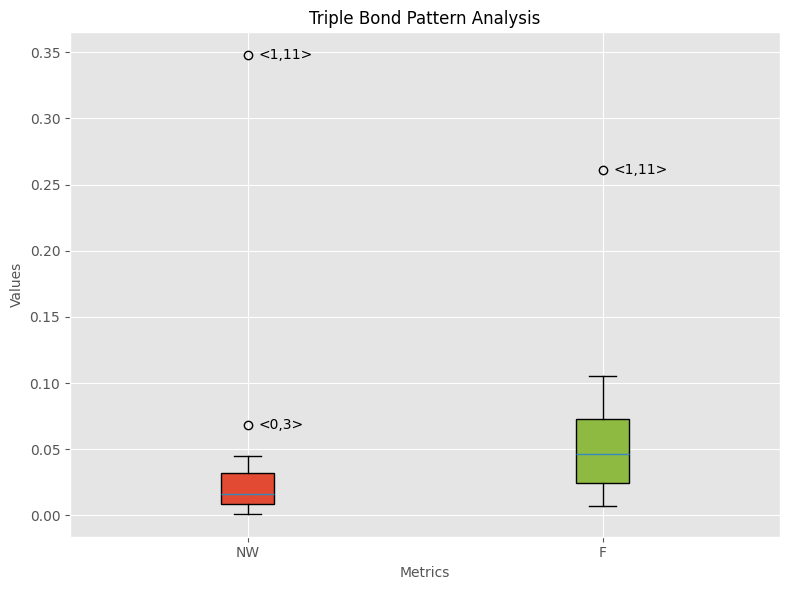

In [ ]:
# Analyze bond pattern
print("=== Analyzing Triple Bond Pattern ===")
all_tp_bond, all_fp_bond, all_fn_bond, all_count_bond, all_wocc_bond, all_sum_bond = analyze_pattern('triple bond')
f_m_bond, n_w_bond, r_c_bond, pre_bond, recal_bond = calculate_metrics(
    all_tp_bond, all_fp_bond, all_fn_bond, all_count_bond, all_wocc_bond, all_sum_bond)

plot_results(n_w_bond, f_m_bond, "Triple Bond Pattern Analysis", 'triple_bond_pattern.png')

## Functional Group Attention Analysis
This section analyzes how different attention heads in a transformer model focus on specific chemical functional groups in SMILES strings.


## 1. Setup and Imports

In [ ]:
import pickle
import gzip
import pandas as pd
import torch
import numpy as np
from rdkit import Chem
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set style for plots
plt.style.use("ggplot")


In [ ]:
# Configuration
HEAD_LAYER_INDEX = [1,2,3,11,15,16,17,18,19,22,23,24,25,26,27,28,29,30,31,32,33,34,35]

# Generate head layer labels
head_layer_labels = []
for i in range(3):
    for j in range(12):
        if (i*12 + j) in HEAD_LAYER_INDEX:
            head_layer_labels.append(f'l:{i} , h:{j}')

## 2. Data Loading

In [ ]:
# Load SMILES data
def load_smiles_data(file_path):
    """Load SMILES data from gzipped pickle file"""
    smiles_data = []
    with gzip.open(file_path, 'rb') as f:
        while True:
            try:
                smiles_data.extend(pickle.load(f))
            except EOFError:
                break
    return smiles_data

# Load all SMILES
def load_all_smiles(file_path):
    """Load all SMILES from pickle file"""
    with open(file_path, "rb") as f:
        return pickle.load(f)

def load_pickle_data(file_path):
    """Load data from pickle file"""
    with open(file_path, "rb") as f:
        return pickle.load(f)

In [ ]:
# Load the data
smiles_data = load_smiles_data("/content/drive/MyDrive/ChemBERTa Attention Analysis/smiles_attention_data.pkl.gz")
# all_smiles = load_all_smiles("/content/drive/MyDrive/ChemBERTa Attention Analysis/all_smiles")
my_smiles = load_pickle_data("/content/drive/MyDrive/ChemBERTa Attention Analysis/smiles with data")

## 3. Functional Group Data Preparation

In [ ]:
# Load functional groups data
fg_df = pd.read_csv('/content/drive/MyDrive/ChemBERTa Attention Analysis/FunctionalGroups.csv')

# Selected functional groups
selected_fg = ['arene', 'benzene ring', 'carbonyl', 'amine', 'heteroarene', 'ether', 'azaarene',
               'amine, tertiary', 'carboxamide', 'alkene', 'aniline', 'carboxamide, secondary',
               'nitrile', 'α,β-unsaturated carbonyl', 'alkanol', 'ester (carboxylate ester)',
               'phosphonate monoester or diester', 'aryl halide', 'carboxamide, tertiary',
               'amine, secondary', 'carboxylic acid', 'aryl fluoride', 'leaving group', 'imide',
               'amine, primary', 'aryl iodide', 'alkyl fluoride', 'alkyl halide', 'sulfide',
               'acetal', 'ketone', 'ketone or aldehyde', 'N-acylcarbamate or urea (mixed imide)',
               'cyanamide', 'phosphonic acid or monoester', 'iminyl', 'sulfonamide', '1,2-diol',
               'enamine', 'alkyne', 'thiocarbonyl', 'phosphine', 'lactam', 'phosphinic acid',
               'phosphinate ester', 'phosphine oxide', 'thiourea', 'phosphate triester', 'enol ether']

# Create mappings
fg_map = {}
i = 0
for name in fg_df['Functional group']:
    if name in selected_fg:
        fg_map[name] = i
        i += 1

fgc_map = {}
for i, name in enumerate(fg_df['Category'].unique()):
    fgc_map[name] = i


In [ ]:
# Function to convert atom indices to token indices
def convert_ai_ti(matches, tokens):
    """Convert atom indices to token indices"""
    atom_idx = []
    for match in matches:
        for j in match:
            atom_idx.append(j)

    vec2 = []
    ai = 0
    ti = 0
    for c in tokens:
        if c.isalpha():
            if ai in atom_idx:
                vec2.append(ti)
            ai += 1
        ti += 1
    return vec2

In [ ]:
# Extract functional groups from all SMILES
my_smiles_fgs = []
for i, s in tqdm(enumerate(my_smiles), total=len(my_smiles)):
    f_list = []
    mol = Chem.MolFromSmiles(s)
    for _, row in fg_df.iterrows():
        functional_group = Chem.MolFromSmarts(row['SMART'])
        matches = mol.GetSubstructMatches(functional_group)
        tokens = smiles_data[i]['tokens']
        if len(matches) > 0:
            f_list.append([row['Functional group'], convert_ai_ti(matches, tokens), row['Category']])
    my_smiles_fgs.append(f_list)

  0%|          | 0/16456 [00:00<?, ?it/s]

In [ ]:
# Prepare attention data for analysis
all_FG = []
all_FGC = []
all_A = []
all_M = []

for idx, d in tqdm(enumerate(smiles_data), total=len(smiles_data)):
    # Initialize functional group tensors
    FG = torch.zeros((len(fg_map), len(d['tokens'])))
    FGC = torch.zeros((len(fgc_map), len(d['tokens'])))

    # Fill FG and FGC tensors
    for row in my_smiles_fgs[idx]:
        for j in row[1]:
            if row[0] in selected_fg:
                FG[fg_map[row[0]], j] = 1
                FGC[fgc_map[row[2]], j] = 1

    all_FG.append(FG)
    all_FGC.append(FGC)

    # Extract attention and mask data
    A_lh = []
    M_lh = []
    for i in range(3):
        for j in range(12):
            if (i*12 + j) in HEAD_LAYER_INDEX:
                A = d['A'][i][j][:, 1:-1]
                M = d['M'][i][j][:, 1:-1]
                A_lh.append(A)
                M_lh.append(M)

    all_A.append(A_lh)
    all_M.append(M_lh)

  0%|          | 0/16456 [00:00<?, ?it/s]

## 4. Attention Analysis (F-measure and NAW-measure)

In [ ]:
# Analyze attention patterns for all functional groups
naw = []  # Normalized Attention Weight
fms = []  # F-measure scores

for f in tqdm(range(len(fg_map)), desc="Functional Groups"):
    naw_lh = []
    fm_lh = []

    for l in range(3):
        for h in range(12):
            if (l*12 + h) in HEAD_LAYER_INDEX:
                lh = HEAD_LAYER_INDEX.index(l*12 + h)
                sorat = 0
                makhraj = 0
                TP = 0
                FP = 0
                FN = 0

                for d in range(len(smiles_data)):
                    if not torch.all(all_FG[d][f] == torch.zeros(len(all_FG[d][f]))):
                        # Calculate metrics
                        TP += (all_FG[d][f] * (all_M[d][lh].any(0))).sum().item()
                        FP += ((1 - all_FG[d][f]) * (all_M[d][lh].any(0))).sum().item()
                        FN += (all_FG[d][f] * ~(all_M[d][lh].any(0))).sum().item()

                        # Calculate attention weights
                        sorat += (all_FG[d][f] * (all_M[d][lh] * all_A[d][lh]).sum(0)).sum()
                        makhraj += (all_M[d][lh] * all_A[d][lh]).sum()

                # Append results
                naw_lh.append(sorat.item() / makhraj.item() if makhraj != 0 else 0)
                fm_lh.append((2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) != 0 else 0)

    naw.append(naw_lh)
    fms.append(fm_lh)

# Convert to numpy arrays
naw_array = np.transpose(np.array(naw))
fms_array = np.transpose(np.array(fms))


Functional Groups:   0%|          | 0/49 [00:00<?, ?it/s]

## 5. Visualization

In [ ]:
# Function to get layer-head label
def getlh(s):
    sp1 = s.split(',')
    l = sp1[0].split(':')[1].strip()
    h = sp1[1].split(':')[1].strip()
    return f'<{l},{h}>'

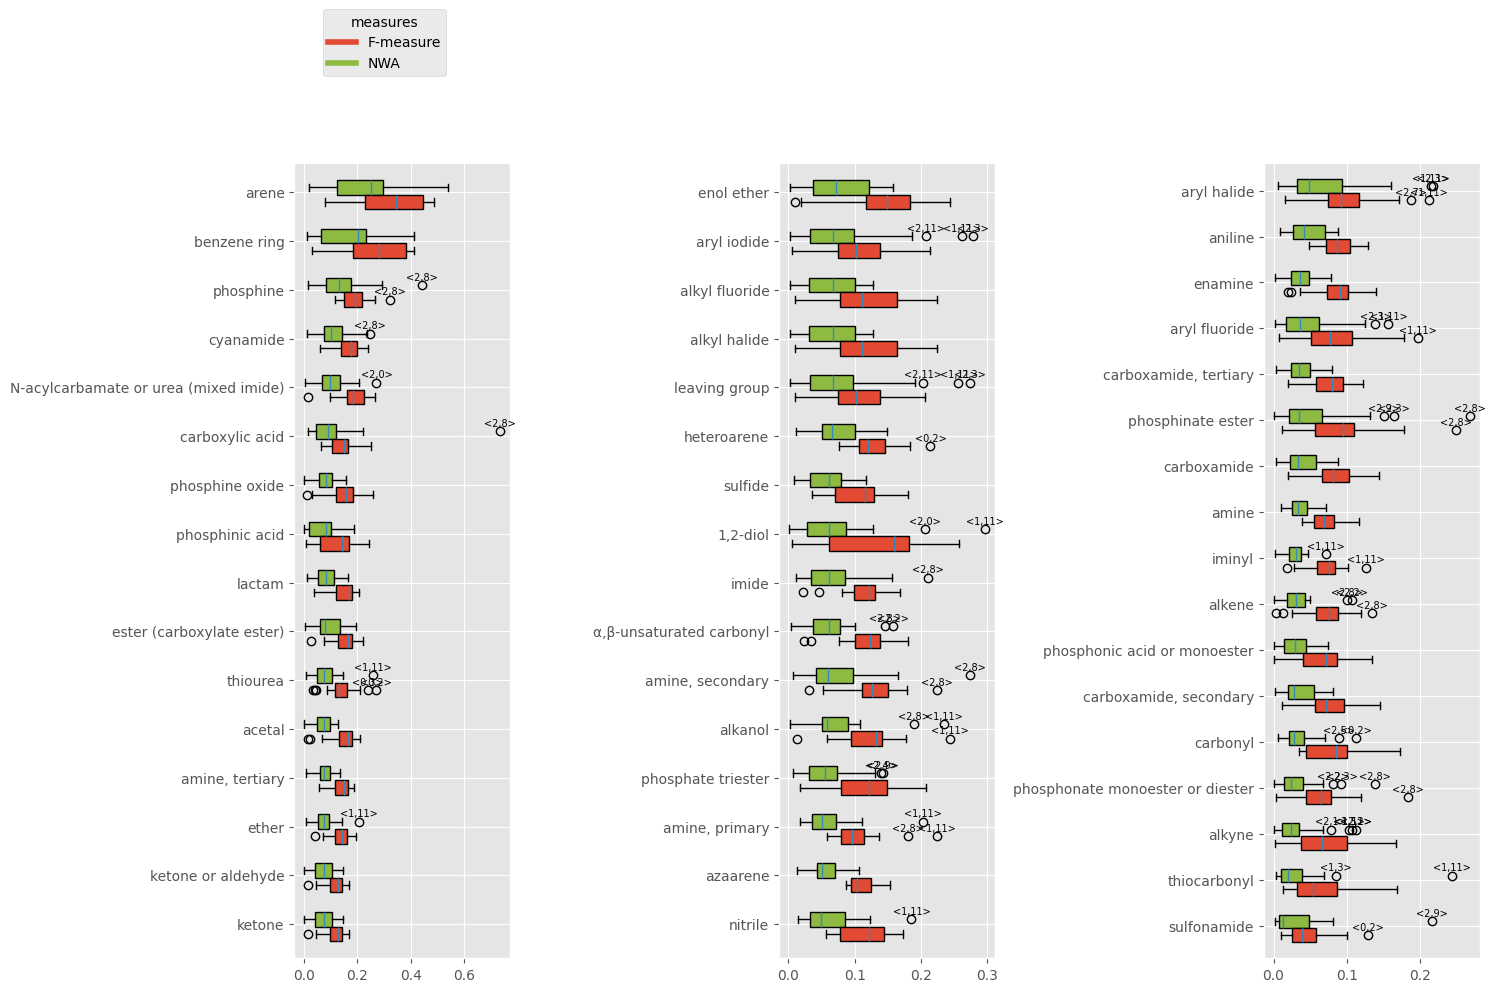

In [ ]:
# Prepare data for plotting
means = np.median(naw_array, axis=0)
sorted_indices = np.argsort(means)[::-1]
sorted_data = naw_array[:, sorted_indices]
fms_data = fms_array[:, sorted_indices]
sorted_sel_fg_name = np.array(list(fg_map.keys()))[sorted_indices]

outlier_fg = {fg: ([], []) for fg in sorted_sel_fg_name}

# Create the plot
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1, 3, figure=fig)

ax = [fig.add_subplot(gs[0, 0]),
      fig.add_subplot(gs[0, 1]),
      fig.add_subplot(gs[0, 2])]

colors = ["C0", "C5"]

# --------- Panel 1 ----------
for i in range(16):
    box = ax[0].boxplot(sorted_data[:, i],
                        positions=[16 - i - 0.4],
                        widths=0.3,
                        patch_artist=True,
                        boxprops=dict(facecolor=colors[1], edgecolor='black'),
                        vert=False)
    fliers = box['fliers'][0].get_data()[0]
    for outlier in fliers:
        if outlier > np.mean(sorted_data[:, i]):
            s = getlh(head_layer_labels[np.where(sorted_data[:, i] == outlier)[0][0]])
            outlier_fg[sorted_sel_fg_name[i]][0].append(s)
            ax[0].text(y=16 - i - 0.3, x=outlier, s=s,
                       color='black', fontsize=7, ha='center')

for i in range(16):
    box = ax[0].boxplot(fms_data[:, i],
                        positions=[16 - i - 0.7],
                        widths=0.3,
                        patch_artist=True,
                        boxprops=dict(facecolor=colors[0], edgecolor='black'),
                        vert=False, whis=1.5)
    fliers = box['fliers'][0].get_data()[0]
    for outlier in fliers:
        if outlier > np.mean(fms_data[:, i]):
            s = getlh(head_layer_labels[np.where(fms_data[:, i] == outlier)[0][0]])
            outlier_fg[sorted_sel_fg_name[i]][1].append(s)
            ax[0].text(y=16 - i - 0.6, x=outlier, s=s,
                       color='black', fontsize=7, ha='center')

ax[0].set_yticks(np.arange(0.5, 16, 1))
ax[0].set_yticklabels(sorted_sel_fg_name[:16][::-1])

# --------- Panel 2 ----------
for i in range(16):
    box = ax[1].boxplot(sorted_data[:, 16+i],
                        positions=[16 - i - 0.4],
                        widths=0.3,
                        patch_artist=True,
                        boxprops=dict(facecolor=colors[1], edgecolor='black'),
                        vert=False)
    fliers = box['fliers'][0].get_data()[0]
    for outlier in fliers:
        if outlier > np.mean(sorted_data[:, 16+i]):
            s = getlh(head_layer_labels[np.where(sorted_data[:, 16+i] == outlier)[0][0]])
            outlier_fg[sorted_sel_fg_name[16+i]][0].append(s)
            ax[1].text(y=16 - i - 0.3, x=outlier, s=s,
                       color='black', fontsize=7, ha='center')

for i in range(16):
    box = ax[1].boxplot(fms_data[:, 16+i],
                        positions=[16 - i - 0.7],
                        widths=0.3,
                        patch_artist=True,
                        boxprops=dict(facecolor=colors[0], edgecolor='black'),
                        vert=False, whis=1.5)
    fliers = box['fliers'][0].get_data()[0]
    for outlier in fliers:
        if outlier > np.mean(fms_data[:, 16+i]):
            s = getlh(head_layer_labels[np.where(fms_data[:, 16+i] == outlier)[0][0]])
            outlier_fg[sorted_sel_fg_name[16+i]][1].append(s)
            ax[1].text(y=16 - i - 0.6, x=outlier, s=s,
                       color='black', fontsize=7, ha='center')

ax[1].set_yticks(np.arange(0.5, 16, 1))
ax[1].set_yticklabels(sorted_sel_fg_name[16:32][::-1])

# --------- Panel 3 ----------
for i in range(17):
    box = ax[2].boxplot(sorted_data[:, 32+i],
                        positions=[17 - i - 0.4],
                        widths=0.3,
                        patch_artist=True,
                        boxprops=dict(facecolor=colors[1], edgecolor='black'),
                        vert=False)
    fliers = box['fliers'][0].get_data()[0]
    for outlier in fliers:
        if outlier > np.mean(sorted_data[:, 32+i]):
            s = getlh(head_layer_labels[np.where(sorted_data[:, 32+i] == outlier)[0][0]])
            outlier_fg[sorted_sel_fg_name[32+i]][0].append(s)
            ax[2].text(y=17 - i - 0.3, x=outlier, s=s,
                       color='black', fontsize=7, ha='center')

for i in range(17):
    box = ax[2].boxplot(fms_data[:, 32+i],
                        positions=[17 - i - 0.7],
                        widths=0.3,
                        patch_artist=True,
                        boxprops=dict(facecolor=colors[0], edgecolor='black'),
                        vert=False, whis=1.5)
    fliers = box['fliers'][0].get_data()[0]
    for outlier in fliers:
        if outlier > np.mean(fms_data[:, 32+i]):
            s = getlh(head_layer_labels[np.where(fms_data[:, 32+i] == outlier)[0][0]])
            outlier_fg[sorted_sel_fg_name[32+i]][1].append(s)
            ax[2].text(y=17 - i - 0.6, x=outlier, s=s,
                       color='black', fontsize=7, ha='center')

ax[2].set_yticks(np.arange(0.5, 17, 1))
ax[2].set_yticklabels(sorted_sel_fg_name[32:][::-1])

# --------- Legend ----------
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
labels = ['F-measure', 'NWA']
ax[0].legend(handles, labels, title='measures',
             loc='lower left', bbox_to_anchor=(0.1, 1.1), ncol=1)

plt.tight_layout()
plt.savefig("boxplot_results.png", dpi=600, bbox_inches="tight")
plt.show()

# AMPC_Struct

## Structural Attention Analysis
This section analyzes the relationship between molecular structure (represented by Coulomb matrices) and attention patterns in chemical models.

## 1. Setup and Imports

In [ ]:
import pickle
import gzip
import torch
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set style for plots
plt.style.use("ggplot")


In [ ]:
# Configuration
HEAD_LAYER_INDEX = [1, 2, 3, 11, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

# Generate head layer labels
head_layer_labels = []
for i in range(3):
    for j in range(12):
        if (i * 12 + j) in HEAD_LAYER_INDEX:
            head_layer_labels.append(f'l:{i} , h:{j}')

## 2. Data Loading Functions

In [ ]:
def load_smiles_data(file_path):
    """Load SMILES data from gzipped pickle file"""
    smiles_data = []
    with gzip.open(file_path, 'rb') as f:
        while True:
            try:
                smiles_data.extend(pickle.load(f))
            except EOFError:
                break
    return smiles_data

def load_all_smiles(file_path):
    """Load all SMILES from pickle file"""
    with open(file_path, "rb") as f:
        return pickle.load(f)

def load_pickle_data(file_path):
    """Load data from pickle file"""
    with open(file_path, "rb") as f:
        return pickle.load(f)

In [ ]:
# Load the data
# all_smiles = load_all_smiles("/content/drive/MyDrive/ChemBERTa Attention Analysis/all_smiles")
smiles_data = load_smiles_data("/content/drive/MyDrive/ChemBERTa Attention Analysis/smiles_attention_data.pkl.gz")
my_smiles = load_pickle_data("/content/drive/MyDrive/ChemBERTa Attention Analysis/smiles with data")

## 3. Coulomb Matrix Functions

In [ ]:
def coulomb_matrix(smiles, num_confs=3, maxIters=50):
    """Generate Coulomb matrix for a SMILES string"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol = Chem.AddHs(mol)

    # Generate conformers with ETKDGv3
    params = AllChem.ETKDGv3()
    cids = AllChem.EmbedMultipleConfs(mol, numConfs=num_confs, params=params)
    if not cids:
        return None

    # Optimize conformers
    res = AllChem.UFFOptimizeMoleculeConfs(mol, maxIters=maxIters)
    energies = [r[1] for r in res]

    # Pick lowest-energy conformer
    best_conf_id = int(np.argmin(energies))
    conf = mol.GetConformer(best_conf_id)

    num_atoms = mol.GetNumAtoms()
    charges = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])

    # Get positions matrix
    positions = np.array([conf.GetAtomPosition(i) for i in range(num_atoms)])

    # Compute distance matrix
    dists = np.linalg.norm(positions[:, None, :] - positions[None, :, :], axis=-1)
    np.fill_diagonal(dists, 1.0)  # avoid division by zero

    # Coulomb matrix
    cm = np.outer(charges, charges) / dists
    np.fill_diagonal(cm, 0.5 * charges ** 2.4)

    # Remove hydrogens
    heavy_idx = [i for i, atom in enumerate(mol.GetAtoms()) if atom.GetAtomicNum() != 1]
    cm = cm[np.ix_(heavy_idx, heavy_idx)]

    return cm


In [ ]:
def compute_all_coulomb(smiles_list, n_jobs=8):
    """Compute Coulomb matrices for all SMILES in parallel"""
    results = Parallel(n_jobs=n_jobs)(
        delayed(coulomb_matrix)(smiles) for smiles in tqdm(smiles_list, desc="Computing Coulomb matrices")
    )
    # Filter out None results
    coulomb_matrix_list = [cm for cm in results if cm is not None]
    valid_indices = [i for i, cm in enumerate(results) if cm is not None]
    return coulomb_matrix_list, valid_indices

def save_coulomb_matrices(cms, indices, file_path):
    """Save Coulomb matrices to file"""
    data = {'cms': cms, 'idx': indices}
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

def load_coulomb_matrices(file_path):
    """Load Coulomb matrices from file"""
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data['cms'], data['idx']


In [ ]:
# Compute or load Coulomb matrices
try:
    cms, cidx = load_coulomb_matrices('/content/drive/MyDrive/ChemBERTa Attention Analysis/my_coulomb_matrices.pkl')
    print("Loaded precomputed Coulomb matrices")
except:
    print("Computing Coulomb matrices...")
    cms, cidx = compute_all_coulomb(my_smiles, n_jobs=8)
    save_coulomb_matrices(cms, cidx, '/content/drive/MyDrive/ChemBERTa Attention Analysis/my_coulomb_matrices.pkl')

Loaded precomputed Coulomb matrices


## 4. Attention Matrix Processing

In [ ]:
def pruning_attention_matrices(smiles_data):
    """Extract attention matrices for atoms only (excluding non-atom tokens)"""
    print("Extracting atom attention matrices...")

    for data in tqdm(smiles_data, desc="Processing attention matrices"):
        tokens = data['tokens']
        # Find indices of atom tokens (alphabetic characters)
        atom_indices = []
        for i in range(len(tokens)):
            if tokens[i].isalpha():
                atom_indices.append(i + 1)  # +1 to account for [CLS] token

        # Extract attention matrices for atoms only
        A = []
        for l in range(3):
            layer_attentions = []
            for h in range(12):
                att = data['A'][l][h]
                # Extract attention for atoms only
                atom_att = att[:, atom_indices][atom_indices, :]
                layer_attentions.append(atom_att)
            A.append(torch.stack(layer_attentions))

        # Store the atom-only attention matrices
        data['co'] = torch.stack(A, dim=0)

    return smiles_data

In [ ]:
# Process attention matrices
smiles_data = pruning_attention_matrices(smiles_data)

Extracting atom attention matrices...


Processing attention matrices:   0%|          | 0/16456 [00:00<?, ?it/s]

## 5. Similarity Analysis Functions

In [ ]:
def cosine_similarity(m1, m2):
    """Calculate cosine similarity between two matrices"""
    # Normalize matrices
    m1_normalized = m1 / m1.sum(axis=1, keepdims=True)
    m1_normalized = np.nan_to_num(m1_normalized, nan=0.0)

    m2_normalized = m2 / m2.sum(axis=1, keepdims=True)
    m2_normalized = np.nan_to_num(m2_normalized, nan=0.0)

    # Flatten matrices and calculate cosine similarity
    dot_product = np.dot(m1_normalized.flatten('F'), m2_normalized.flatten('F'))
    m1_norm = np.linalg.norm(m1_normalized)
    m2_norm = np.linalg.norm(m2_normalized)

    if m1_norm == 0 or m2_norm == 0:
        return 0.0

    cos_sim = dot_product / (m1_norm * m2_norm)
    return cos_sim

def calculate_average_cosine_similarity(cms, smiles_data, cidx, head_layer_index):
    """Calculate average cosine similarity between Coulomb matrices and attention matrices"""
    print("Calculating average cosine similarity...")

    avg_cosine_sim = []

    for layer in range(3):
        for head in range(12):
            if (layer * 12 + head) in head_layer_index:
                total_similarity = 0.0
                valid_count = 0

                for i in range(len(cms)):
                    data_idx = cidx[i]
                    try:
                        # Get attention matrix for this layer and head
                        att_matrix = smiles_data[data_idx]['co'][layer][head].numpy()

                        # Calculate cosine similarity
                        similarity = cosine_similarity(cms[i], att_matrix)
                        total_similarity += similarity
                        valid_count += 1
                    except (IndexError, KeyError):
                        continue

                # Calculate average similarity
                if valid_count > 0:
                    avg_similarity = total_similarity / valid_count
                else:
                    avg_similarity = 0.0

                avg_cosine_sim.append(avg_similarity)

    return avg_cosine_sim

In [ ]:
# Calculate average cosine similarity
avg_cosine_sim = calculate_average_cosine_similarity(cms, smiles_data, cidx, HEAD_LAYER_INDEX)

Calculating average cosine similarity...


## 6. Visualization Functions

In [ ]:
def get_layer_head_label(s):
    """Extract layer and head from label string"""
    sp1 = s.split(',')
    l = sp1[0].split(':')[1].strip()
    h = sp1[1].split(':')[1].strip()
    return f'<{l},{h}>'

def plot_cosine_similarity_results(avg_cosine_sim, head_layer_labels, save_path=None):
    """Plot cosine similarity results"""
    colors = ["C2"]  # Green color for cosine similarity

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    # Create boxplot
    box = ax.boxplot(avg_cosine_sim, patch_artist=True, whis=0.8)

    # Set color for the boxplot
    box['boxes'][0].set_facecolor(colors[0])

    # Handle outliers
    outliers = box['fliers'][0].get_data()[1]
    outlier_labels = []
    for outlier in outliers:
        outlier_labels.append(get_layer_head_label(
            np.array(head_layer_labels)[np.where(np.array(avg_cosine_sim) == outlier)[0][0]]))

    # Add outlier labels
    for i in range(len(outlier_labels)):
        ax.text(1.03, outliers[i], outlier_labels[i],
                ha='left', va='center', fontsize=10, color='black')

    # Set labels and title
    ax.set_xticklabels(['Cosine Similarity'], fontsize=14)
    ax.set_ylabel('Similarity Score', fontsize=12)
    ax.set_title('Cosine Similarity between Coulomb Matrices and Attention Patterns', fontsize=12)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

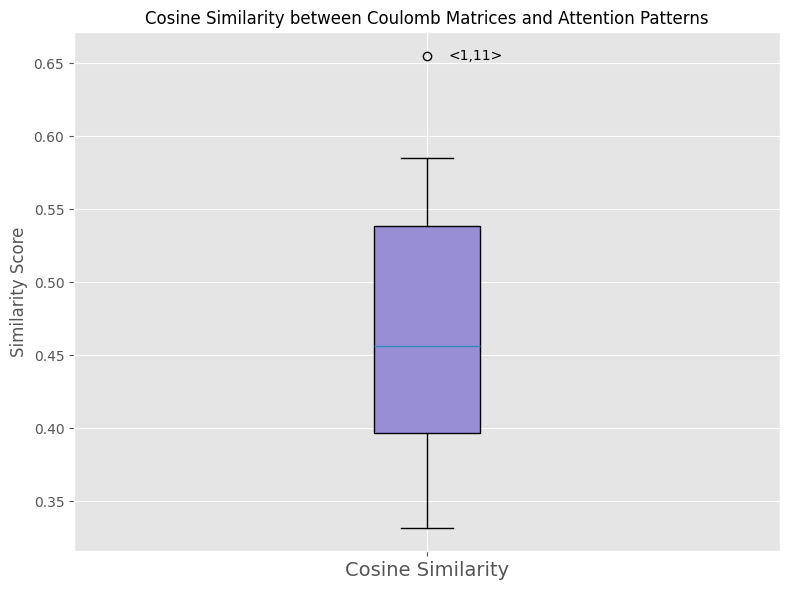

In [ ]:
# Plot results
plot_cosine_similarity_results(avg_cosine_sim, head_layer_labels, 'results_picture_Struct.png')